<h1 style="color: navy bleu;text-align:center">  M2 MAS DS - Data mining : Caravan insurance

<h3 style="color: navy bleu"> Saïda Guezoui, groupe DS </h3>
<h3 style="color: navy bleu"> Thomas Lo Coco, groupe DS </h3>

<h3 style="color: navy bleu"> Objectif 

L'objectif de ce projet est de prédire si la personne prendra l'assurance Caravan ou pas. On cherche également à décrire les profils des clients qui sont intéressés par cette assurance. Autrement dit, dégager des profils types afin de pouvoir cibler ce genre de personnes. 

<h3 style="color: navy bleu"> Chargement des bibliothèques

In [149]:
# Calcul, manipulation et affichage des données
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Test du Chi 2
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest

# Modèles
from sklearn import svm
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# rééchantillonnage
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks

# Métriques
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report

<h2 style="color: navy bleu">I. Chargement des données

In [150]:
data_set = pd.read_csv("caravan-insurance-challenge.csv")

# Séparation du jeu de données
data_set_train = data_set[data_set["ORIGIN"] == "train"]
data_set_test  = data_set[data_set["ORIGIN"] == "test"]

# Séparation des observations et des classes
y_train = data_set_train["CARAVAN"]
X_train = data_set_train.copy().drop(["ORIGIN", "CARAVAN"], axis = 1)

y_test = data_set_test["CARAVAN"]
X_test = data_set_test.copy().drop(["ORIGIN", "CARAVAN"], axis = 1)

<h2 style="color: navy bleu"> II. Pré-traitement des données 

Comme la majorité des variables sont qualitatives, on décide donc de faire un test de Khi2 avec un seuil de 5%. 

<h3 style="color: navy bleu"> A. Test du $X^2$

In [151]:
X_quali = data_set_train.drop(["ORIGIN", "CARAVAN","MAANTHUI","MGEMOMV"], axis = 1)
y = data_set_train["CARAVAN"]

chi2_selector = SelectKBest(chi2, k=2)
chi2_selector.fit(X_quali, y)

chi2_scores = pd.DataFrame(list(zip(X_quali.columns, chi2_selector.scores_, chi2_selector.pvalues_)),
                           columns=['Variable', 'score', 'pval'])

kbest = np.asarray(X_quali.columns)[chi2_selector.get_support()]

# Afficher les variables liées à CARAVAN avec un seuil de 5% 
var_dep = round( chi2_scores[chi2_scores["pval"] < 0.05],3)

print(len(var_dep))
pd.DataFrame(var_dep)

55


,Variable,score,pval
0,MOSTYPE,190.697,0.000
2,MOSHOOFD,39.515,0.000
4,MGODPR,4.001,0.045
6,MGODGE,7.932,0.005
7,MRELGE,16.946,0.000
8,MRELSA,6.842,0.009
9,MRELOV,29.258,0.000
10,MFALLEEN,28.171,0.000
12,MFWEKIND,5.695,0.017
13,MOPLHOOG,75.174,0.000


In [152]:
# Affichage des 10 première lignes 
pd.DataFrame(round(chi2_scores.iloc[:10], 2))

,Variable,score,pval
0,MOSTYPE,190.70,0.00
1,MGEMLEEF,0.03,0.87
2,MOSHOOFD,39.51,0.00
3,MGODRK,0.33,0.57
4,MGODPR,4.00,0.05
5,MGODOV,0.09,0.76
6,MGODGE,7.93,0.00
7,MRELGE,16.95,0.00
8,MRELSA,6.84,0.01
9,MRELOV,29.26,0.00


<h3 style="color: navy bleu"> B. Visualisation des données

<h4 style="color: navy bleu"> 1. Label pour le recodage des variables  

In [153]:
val_L3 = [0,1,2,3,4,5,6,7,8,9]
L0 = []
L3 = ['0%', '1-10%', '11-23%', '24-36%', '37-49%', '50-62%', '63-75%', '76-88%', '89-99%', '100%']
L4 = ['0', '1 - 49', '50 - 99', '100 - 199', '200 - 499', '500 - 999', '1000 - 4999', '5000 - 9999',
      '10,000 - 19,999', '>= 20,000']
L1 = ['20-30 years','30-40 years','40-50 years','50-60 years','60-70 years','70-80 years']

In [154]:
var_pval_nulle_0 = {'MOSTYPE' : L0 , 'MOSHOOFD' : L3 , 'MRELGE' : L3, 'MRELOV' : L3,
                    'MFALLEEN' : L3, 'MOPLHOOG' : L3, 'MOPLLAAG' : L3, 'MBERHOOG' : L3,
                    'MBERBOER' : L3, 'MBERMIDD' : L3, 'MBERARBG' : L3, 'MBERARBO' : L3,
                    'MSKA' : L3, 'MSKD' : L3, 'MHHUUR' : L3, 'MHKOOP' : L3, 'MAUT0' : L3,
                    'MZFONDS' : L3 , 'MZPART' : L3, 'MINKM30' : L3, 'MINK4575' : L3,
                    'MINK7512' : L3, 'MINKGEM' : L3, 'MKOOPKLA' : L3, 'PWAPART' : L4,
                    'PPERSAUT' : L4, 'PBROM' : L4, 'PGEZONG' : L4, 'PWAOREG' : L4,
                    'PBRAND' : L4, 'PPLEZIER' : L4, 'PBYSTAND' : L4,'AWAPART' : L4,
                    'APERSAUT' : L4, 'ALEVEN' : L4, 'ABRAND': L4, 'APLEZIER': L4, 'ABSYTAND': L4}

<h4 style="color: navy bleu"> 2. Affichage des croisements entres les variables sélectionnées par le test de Khi2 et CARAVAN 

Remarque : Il y a une partie des croisements faites sur R 

In [155]:
def f(d):
    data_set_train.pivot(columns = 'CARAVAN',values = d).plot.hist(color=['darkblue','#ED7014'],stacked = True,bins=19,
                                                                  orientation = 'horizontal')
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='y',alpha=0.4)
    plt.grid(color='#95a5a6',linestyle='--', linewidth=1,axis='x',alpha=0)
    plt.ylabel(d)
    plt.yticks(np.arange(len(var_pval_nulle[d])), var_pval_nulle[d])
    plt.xlabel("count")
    plt.title('Croisement entre '+ d + ' et CARAVAN')

C:\Users\saida\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:337: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


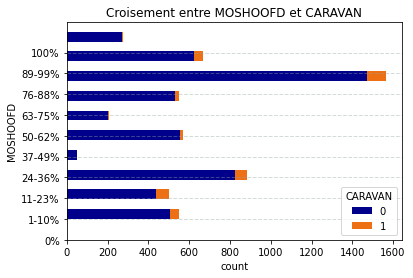

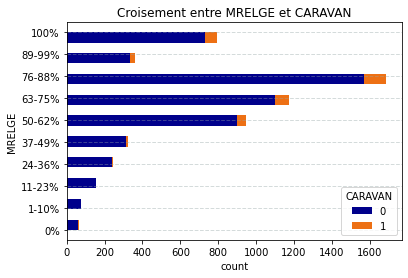

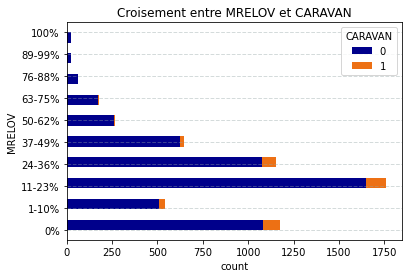

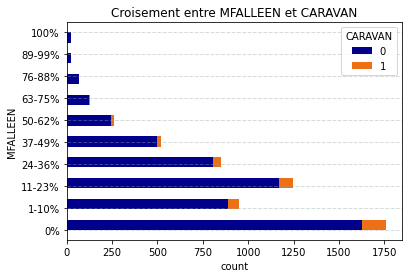

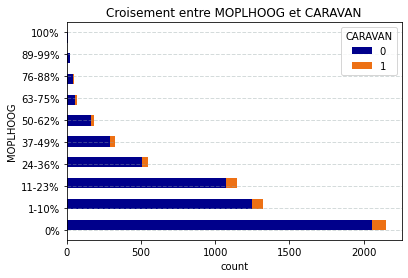

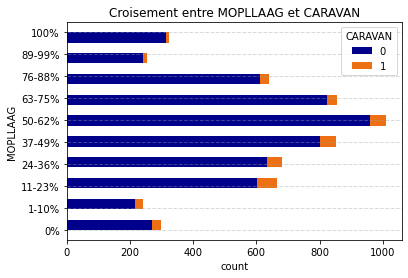

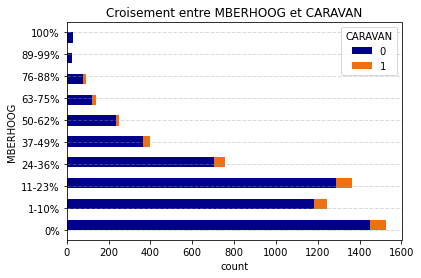

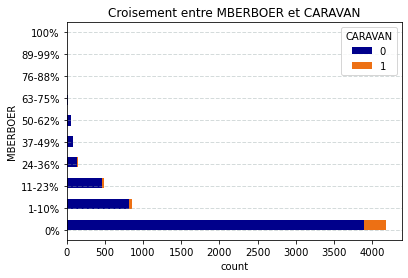

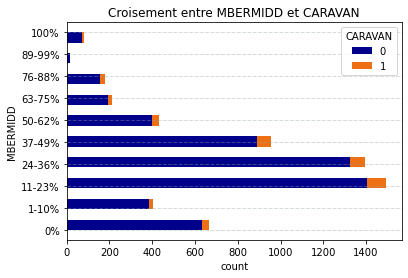

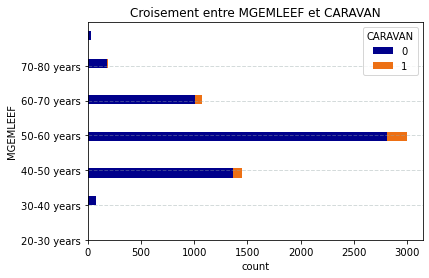

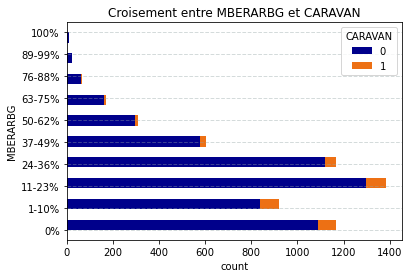

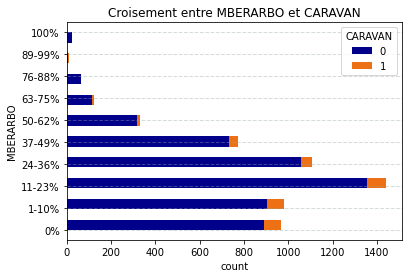

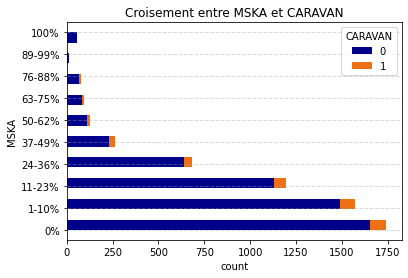

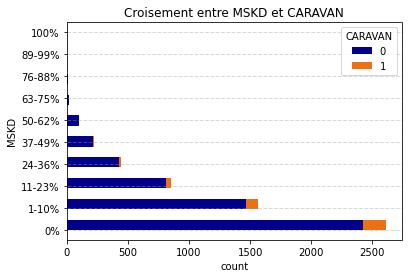

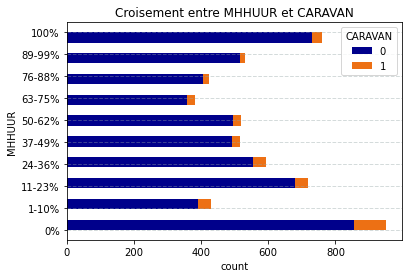

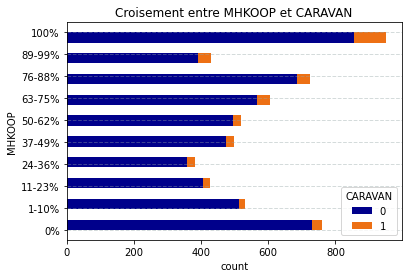

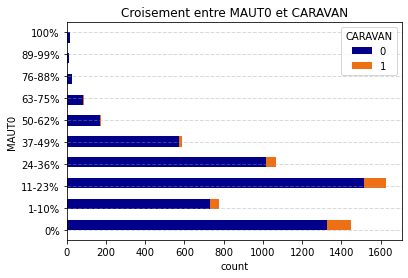

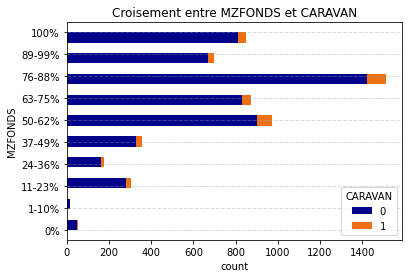

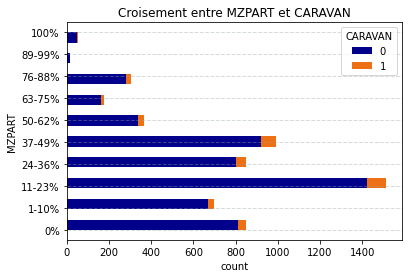

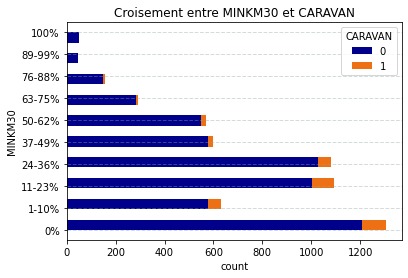

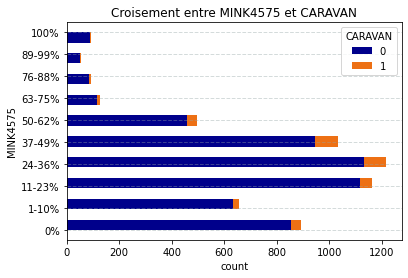

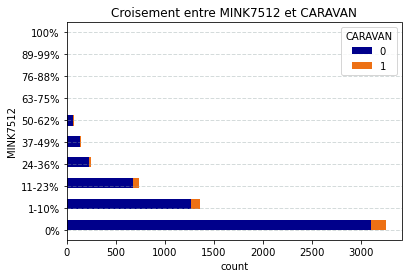

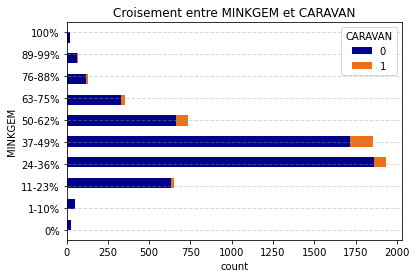

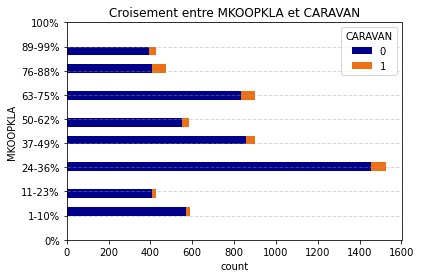

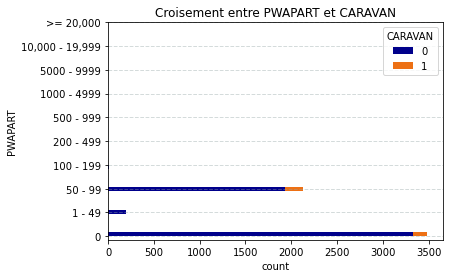

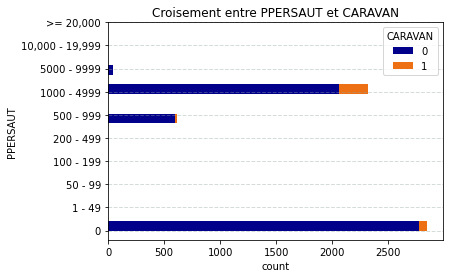

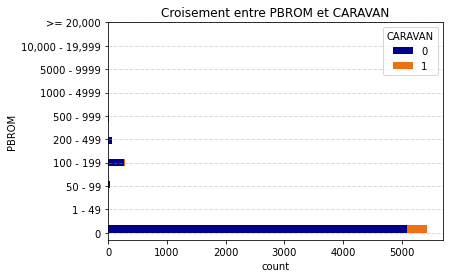

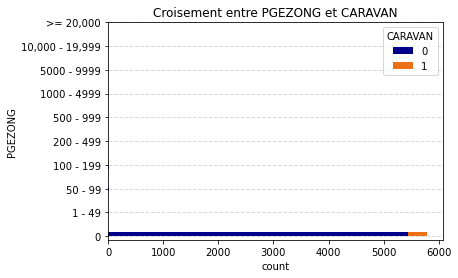

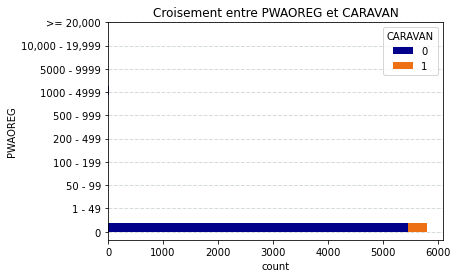

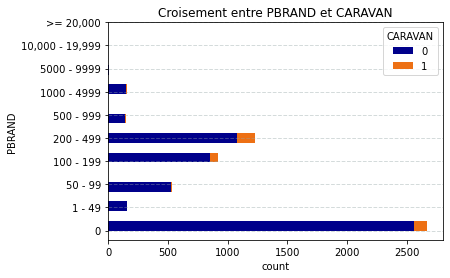

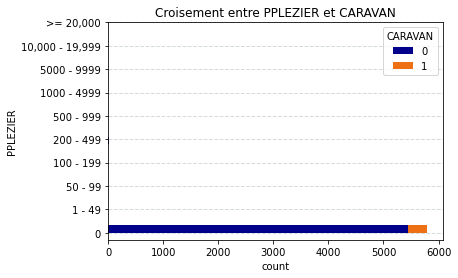

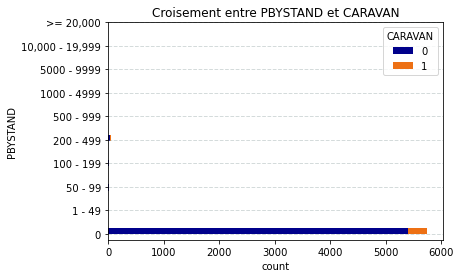

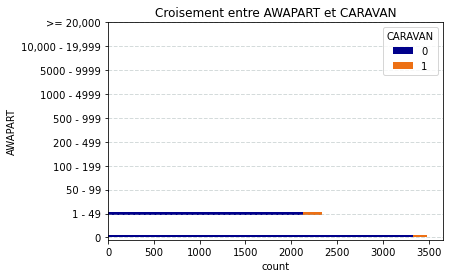

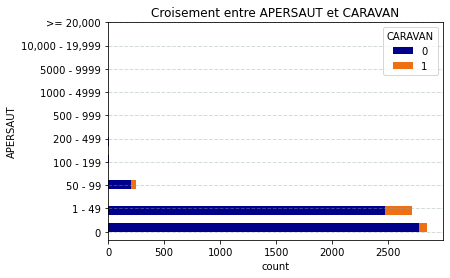

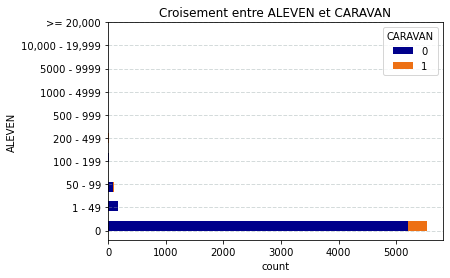

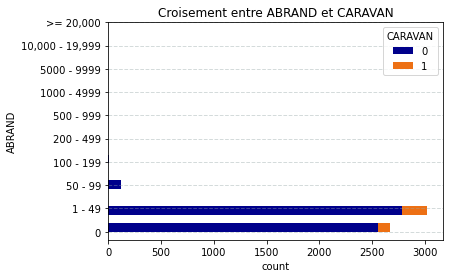

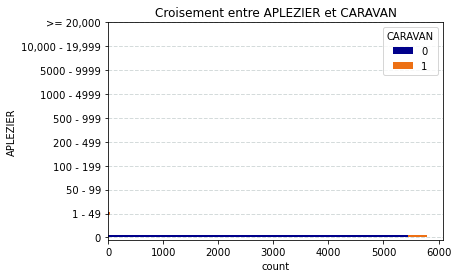

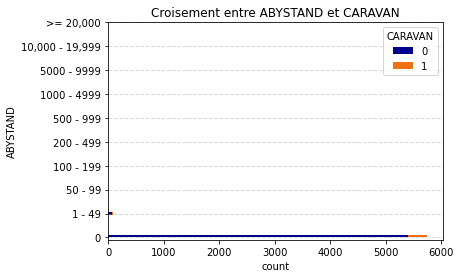

In [156]:
for d in var_pval_nulle:
    f(d)

<h2 style="color: navy bleu"> III. Premières applications de modèles de machine learning

In [157]:
# On définit les modèles que nous allons tester
models = [BernoulliNB(), KNeighborsClassifier(), svm.SVC(kernel="rbf"), DecisionTreeClassifier(),
         RandomForestClassifier()]

In [158]:
# On définit une fonction qui encapsule les routines de tests de nos modèles
def analysis_model(model):
    model.fit(X_train, y_train)
    
    y_predict_train = model.predict(X_train)
    y_predict_test  = model.predict(X_test)
    
    print("Entraînement")
    print(classification_report(y_train, y_predict_train, labels=[0,1]))
    
    print("Test")
    print(classification_report(y_test, y_predict_test, labels=[0,1]))
    
    print("Matrices de confusion")
    ConfusionMatrixDisplay.from_predictions(y_train, y_predict_train, normalize = "true",cmap = plt.cm.Blues)
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, normalize = "true", cmap = plt.cm.Blues)

<h3 style="color: navy bleu"> A. Classifier Bernouilli 

Entraînement
              precision    recall  f1-score   support

           0       0.95      0.93      0.94      5474
           1       0.21      0.30      0.25       348

    accuracy                           0.89      5822
   macro avg       0.58      0.61      0.60      5822
weighted avg       0.91      0.89      0.90      5822

Test
              precision    recall  f1-score   support

           0       0.95      0.92      0.94      3762
           1       0.17      0.24      0.20       238

    accuracy                           0.88      4000
   macro avg       0.56      0.58      0.57      4000
weighted avg       0.90      0.88      0.89      4000

Matrices de confusion


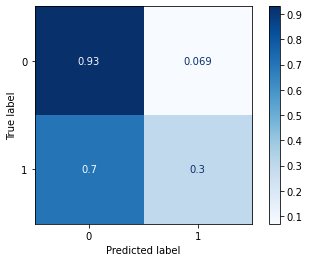

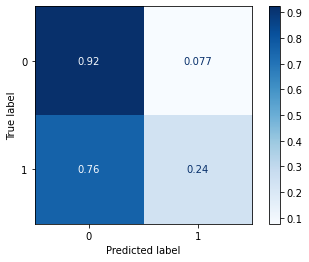

In [160]:
analysis_model(models[0])

<h3 style="color: navy bleu"> B. Classifier K plus prcoches voisins

Entraînement
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5474
           1       0.61      0.05      0.10       348

    accuracy                           0.94      5822
   macro avg       0.78      0.53      0.53      5822
weighted avg       0.92      0.94      0.92      5822

Test
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3762
           1       0.19      0.02      0.03       238

    accuracy                           0.94      4000
   macro avg       0.57      0.51      0.50      4000
weighted avg       0.90      0.94      0.91      4000

Matrices de confusion


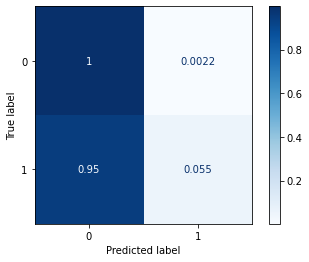

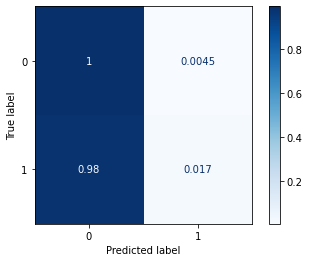

In [161]:
analysis_model(models[1])

<h3 style="color: navy bleu"> C. SVM 

Entraînement
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      5474
           1       0.00      0.00      0.00       348

    accuracy                           0.94      5822
   macro avg       0.47      0.50      0.48      5822
weighted avg       0.88      0.94      0.91      5822

Test
              precision    recall  f1-score   support

           0       0.94      1.00      0.97      3762
           1       0.00      0.00      0.00       238

    accuracy                           0.94      4000
   macro avg       0.47      0.50      0.48      4000
weighted avg       0.88      0.94      0.91      4000

Matrices de confusion


C:\Users\saida\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saida\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saida\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\saida\anaconda3\lib\site-packages\sklearn\metr

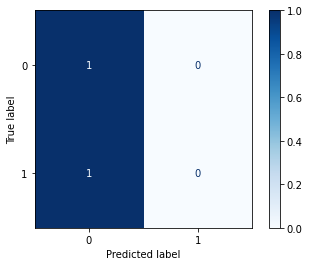

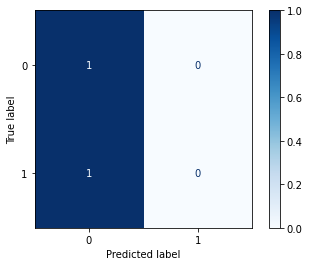

In [162]:
analysis_model(models[2])

<h3 style="color: navy bleu"> D. Arbre de décisions 

Entraînement
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5474
           1       0.99      0.86      0.92       348

    accuracy                           0.99      5822
   macro avg       0.99      0.93      0.96      5822
weighted avg       0.99      0.99      0.99      5822

Test
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3762
           1       0.13      0.14      0.13       238

    accuracy                           0.89      4000
   macro avg       0.54      0.54      0.54      4000
weighted avg       0.90      0.89      0.89      4000

Matrices de confusion


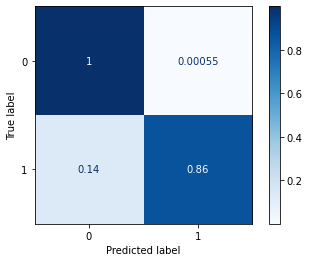

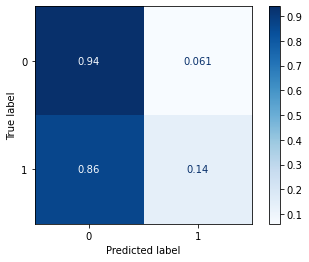

In [163]:
analysis_model(models[3])

<h3 style="color: navy bleu"> E. Forêts aléatoires

Entraînement
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      5474
           1       0.97      0.89      0.92       348

    accuracy                           0.99      5822
   macro avg       0.98      0.94      0.96      5822
weighted avg       0.99      0.99      0.99      5822

Test
              precision    recall  f1-score   support

           0       0.94      0.99      0.96      3762
           1       0.23      0.06      0.09       238

    accuracy                           0.93      4000
   macro avg       0.58      0.52      0.53      4000
weighted avg       0.90      0.93      0.91      4000

Matrices de confusion


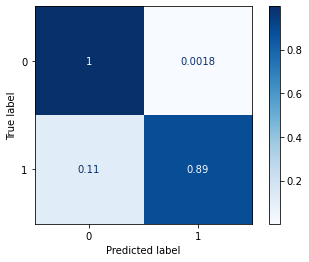

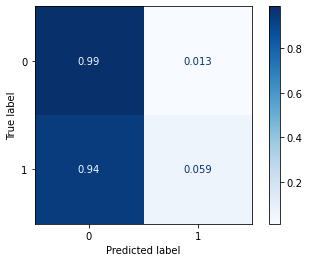

In [164]:
analysis_model(models[4])

<h3 style="color: navy bleu"> F. Comparaison entre les modèles 

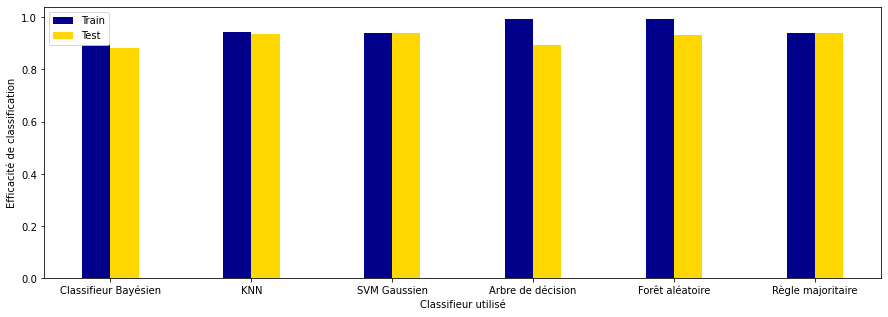

In [212]:
# On compare les résultats des différents modèles en compairon avec la fonction de référence suivante
def function_const_score(y):
    return len(y[y == 0]) / len(y)

méthodes = ['Classifieur Bayésien', 'KNN', 'SVM Gaussien', 
           'Arbre de décision', 'Forêt aléatoire', 'Règle majoritaire']

x = np.arange(6)

bayes = BernoulliNB().fit(X_train, y_train)
knn = KNeighborsClassifier().fit(X_train, y_train)
svc = svm.SVC().fit(X_train, y_train)
decision_tree = DecisionTreeClassifier().fit(X_train, y_train)
forest = RandomForestClassifier().fit(X_train, y_train)

scores_test = [bayes.score(X_test, y_test), knn.score(X_test, y_test), svc.score(X_test, y_test),
         decision_tree.score(X_test, y_test), forest.score(X_test, y_test), function_const_score(y_test)]
scores_train = [bayes.score(X_train, y_train), knn.score(X_train, y_train), svc.score(X_train, y_train),
         decision_tree.score(X_train, y_train), forest.score(X_train, y_train), function_const_score(y_train)]

width = 0.2

plt.figure(figsize = (15,5))
plt.bar(x-0.1, scores_train, width, color='darkblue') 
plt.bar(x+0.1, scores_test, width, color='gold') 
plt.xticks(x, méthodes) 
plt.xlabel("Classifieur utilisé") 
plt.ylabel("Efficacité de classification") 
plt.legend(["Train","Test"])
plt.show()

<h2 style="color: navy bleu"> IV. Seconde application avec rééquilibrage des données

Dans cette partie on va réequilibrer entre la classe 0 et 1. Autrement dit, on prend autant d'éléments de la classe 0 que la classe 1.

In [166]:
X_train_array = np.array(X_train)
y_train_array = np.array(y_train)

X_test_array = np.array(X_test)
y_test_array = np.array(y_test)

index_class_0 = np.where(y_train_array == 0)
index_class_1 = np.where(y_train_array == 1)

X_0 = X_train_array[index_class_0]
y_0 = y_train_array[index_class_0]

X_1 = X_train_array[index_class_1]
y_1 = y_train_array[index_class_1]

nbr = 340
X_train_balanced = np.concatenate((X_0[:nbr],X_1[:nbr]), axis = 0)
y_train_balanced = np.concatenate((y_0[:nbr],y_1[:nbr]), axis = 0)

index = np.arange((nbr*2))
np.random.shuffle(index)

X_train_balanced  = X_train_balanced[index] ; y_train_balanced  = y_train_balanced[index]

In [175]:
def analysis_model_balanced(model):
    model.fit(X_train_balanced, y_train_balanced)
    
    y_predict_train = model.predict(X_train)
    y_predict_test  = model.predict(X_test)
    
    print("Entraînement")
    print(classification_report(y_train, y_predict_train, labels=[0,1]))
    
    print("Test")
    print(classification_report(y_test, y_predict_test, labels=[0,1]))
    
    print("Matrices de confusion")
    ConfusionMatrixDisplay.from_predictions(y_train, y_predict_train, normalize = "true",cmap = plt.cm.Blues)
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, normalize = "true", cmap = plt.cm.Blues)

In [173]:
models = [BernoulliNB(), KNeighborsClassifier(), svm.SVC(kernel="poly"), DecisionTreeClassifier(),
         RandomForestClassifier()]

<h3 style="color: navy bleu"> A. Classifier Bernouilli 

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       0.97      0.69      0.81      5474
           1       0.12      0.67      0.20       348

    accuracy                           0.69      5822
   macro avg       0.55      0.68      0.50      5822
weighted avg       0.92      0.69      0.77      5822

Test
              precision    recall  f1-score   support

           0       0.96      0.68      0.80      3762
           1       0.11      0.61      0.18       238

    accuracy                           0.68      4000
   macro avg       0.54      0.64      0.49      4000
weighted avg       0.91      0.68      0.76      4000

Matrices de confusion train
Matrices de confusion test


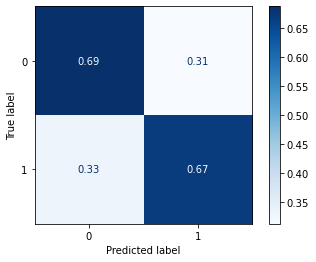

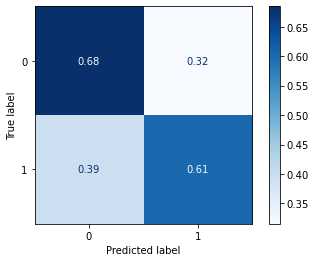

In [174]:
analysis_model_balanced(models[0])

<h3 style="color: navy bleu"> B. Classifieur K plus prcoches voisins 

In [ ]:
analysis_model_balanced(models[1])

<h3 style="color: navy bleu"> C. SVM

In [ ]:
analysis_model_balanced(models[2])

<h3 style="color: navy bleu"> D. Arbre de décisions 

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       1.00      0.64      0.78      5474
           1       0.15      0.99      0.26       348

    accuracy                           0.67      5822
   macro avg       0.57      0.82      0.52      5822
weighted avg       0.95      0.67      0.75      5822

Test
              precision    recall  f1-score   support

           0       0.96      0.62      0.76      3762
           1       0.09      0.58      0.16       238

    accuracy                           0.62      4000
   macro avg       0.52      0.60      0.46      4000
weighted avg       0.91      0.62      0.72      4000

Matrices de confusion


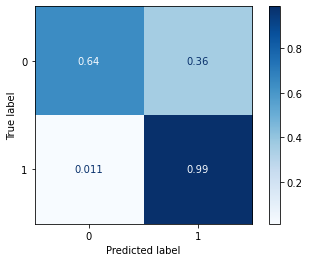

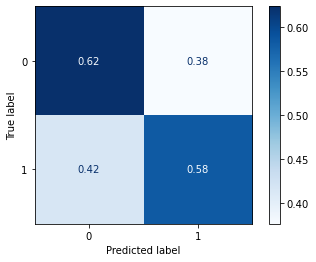

In [193]:
analysis_model_balanced(models[3])

<h3 style="color: navy bleu"> E. Forêts aléatoires

In [ ]:
analysis_model_balanced(models[4])

<h2 style="color: navy bleu"> V. Troisième application avec traitement TomeLink

In [ ]:
from imblearn.under_sampling import TomekLinks

tl = TomekLinks(sampling_strategy = "majority")
X_tl, y_tl = tl.fit_resample(X_train_balanced, y_train_balanced)

In [ ]:
# Affichage du nombre de données après le traitement 
print(X_train_balanced.shape[0], "-->", X_tl.shape[0])

In [ ]:
def analysis_model_tome_links(model):
    model.fit(X_tl, y_tl)
    
    y_predict_train = model.predict(X_train)
    y_predict_test  = model.predict(X_test)
    
    print("Entraînement")
    print(classification_report(y_train, y_predict_train, labels=[0,1]))
    
    print("Test")
    print(classification_report(y_test, y_predict_test, labels=[0,1]))
    
    print("Matrices de confusion")
    ConfusionMatrixDisplay.from_predictions(y_train, y_predict_train, normalize = "true",cmap = plt.cm.Blues)
    ConfusionMatrixDisplay.from_predictions(y_test, y_predict_test, normalize = "true", cmap = plt.cm.Blues)

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but BernoulliNB was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      5474
           1       0.12      0.72      0.20       348

    accuracy                           0.65      5822
   macro avg       0.54      0.69      0.49      5822
weighted avg       0.92      0.65      0.74      5822

Test
              precision    recall  f1-score   support

           0       0.97      0.65      0.78      3762
           1       0.10      0.64      0.18       238

    accuracy                           0.65      4000
   macro avg       0.53      0.64      0.48      4000
weighted avg       0.91      0.65      0.74      4000

Matrices de confusion


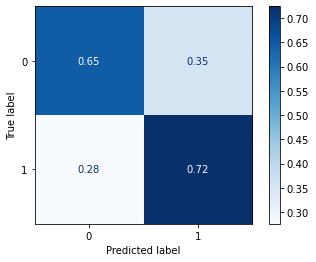

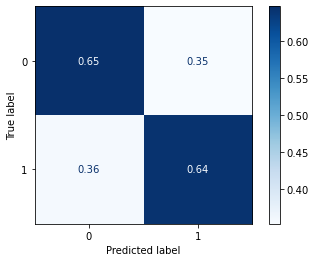

In [168]:
analysis_model_tome_links(models[0])

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       0.98      0.48      0.65      5474
           1       0.09      0.85      0.17       348

    accuracy                           0.50      5822
   macro avg       0.54      0.66      0.41      5822
weighted avg       0.93      0.50      0.62      5822

Test
              precision    recall  f1-score   support

           0       0.97      0.47      0.63      3762
           1       0.08      0.76      0.15       238

    accuracy                           0.48      4000
   macro avg       0.53      0.61      0.39      4000
weighted avg       0.92      0.48      0.60      4000

Matrices de confusion


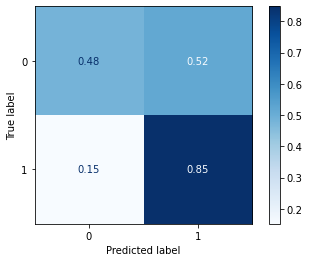

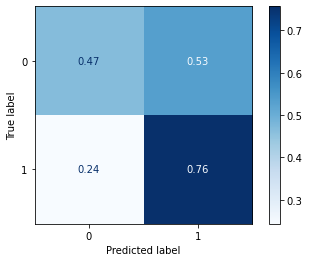

In [169]:
analysis_model_tome_links(models[1])

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SVC was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       0.98      0.51      0.67      5474
           1       0.09      0.81      0.17       348

    accuracy                           0.53      5822
   macro avg       0.54      0.66      0.42      5822
weighted avg       0.92      0.53      0.64      5822

Test
              precision    recall  f1-score   support

           0       0.97      0.52      0.67      3762
           1       0.09      0.74      0.16       238

    accuracy                           0.53      4000
   macro avg       0.53      0.63      0.41      4000
weighted avg       0.92      0.53      0.64      4000

Matrices de confusion


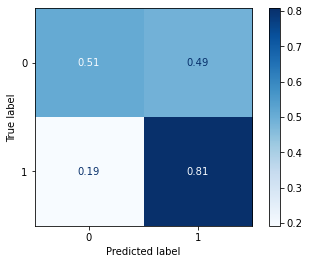

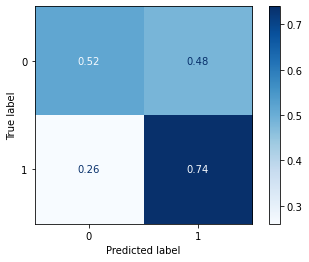

In [170]:
analysis_model_tome_links(models[2])

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


Entraînement
              precision    recall  f1-score   support

           0       1.00      0.59      0.74      5474
           1       0.13      0.99      0.23       348

    accuracy                           0.62      5822
   macro avg       0.57      0.79      0.49      5822
weighted avg       0.95      0.62      0.71      5822

Test
              precision    recall  f1-score   support

           0       0.96      0.59      0.73      3762
           1       0.08      0.57      0.14       238

    accuracy                           0.59      4000
   macro avg       0.52      0.58      0.43      4000
weighted avg       0.90      0.59      0.69      4000

Matrices de confusion


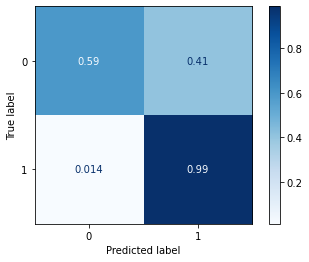

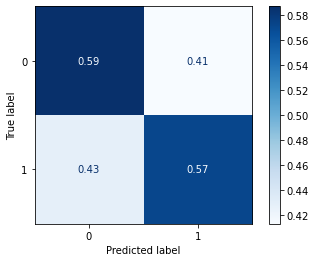

In [171]:
analysis_model_tome_links(models[3])

<h3 style="color: navy bleu"> E. Forêts aléatoires

In [ ]:
analysis_model_tome_links(models[4])

<h2 style="color: navy bleu"> VI. Affichage de l'arbre de décisions et conclusion 

<h3 style="color: navy bleu"> A. Arbre de décisions avec une profondeur de 2 

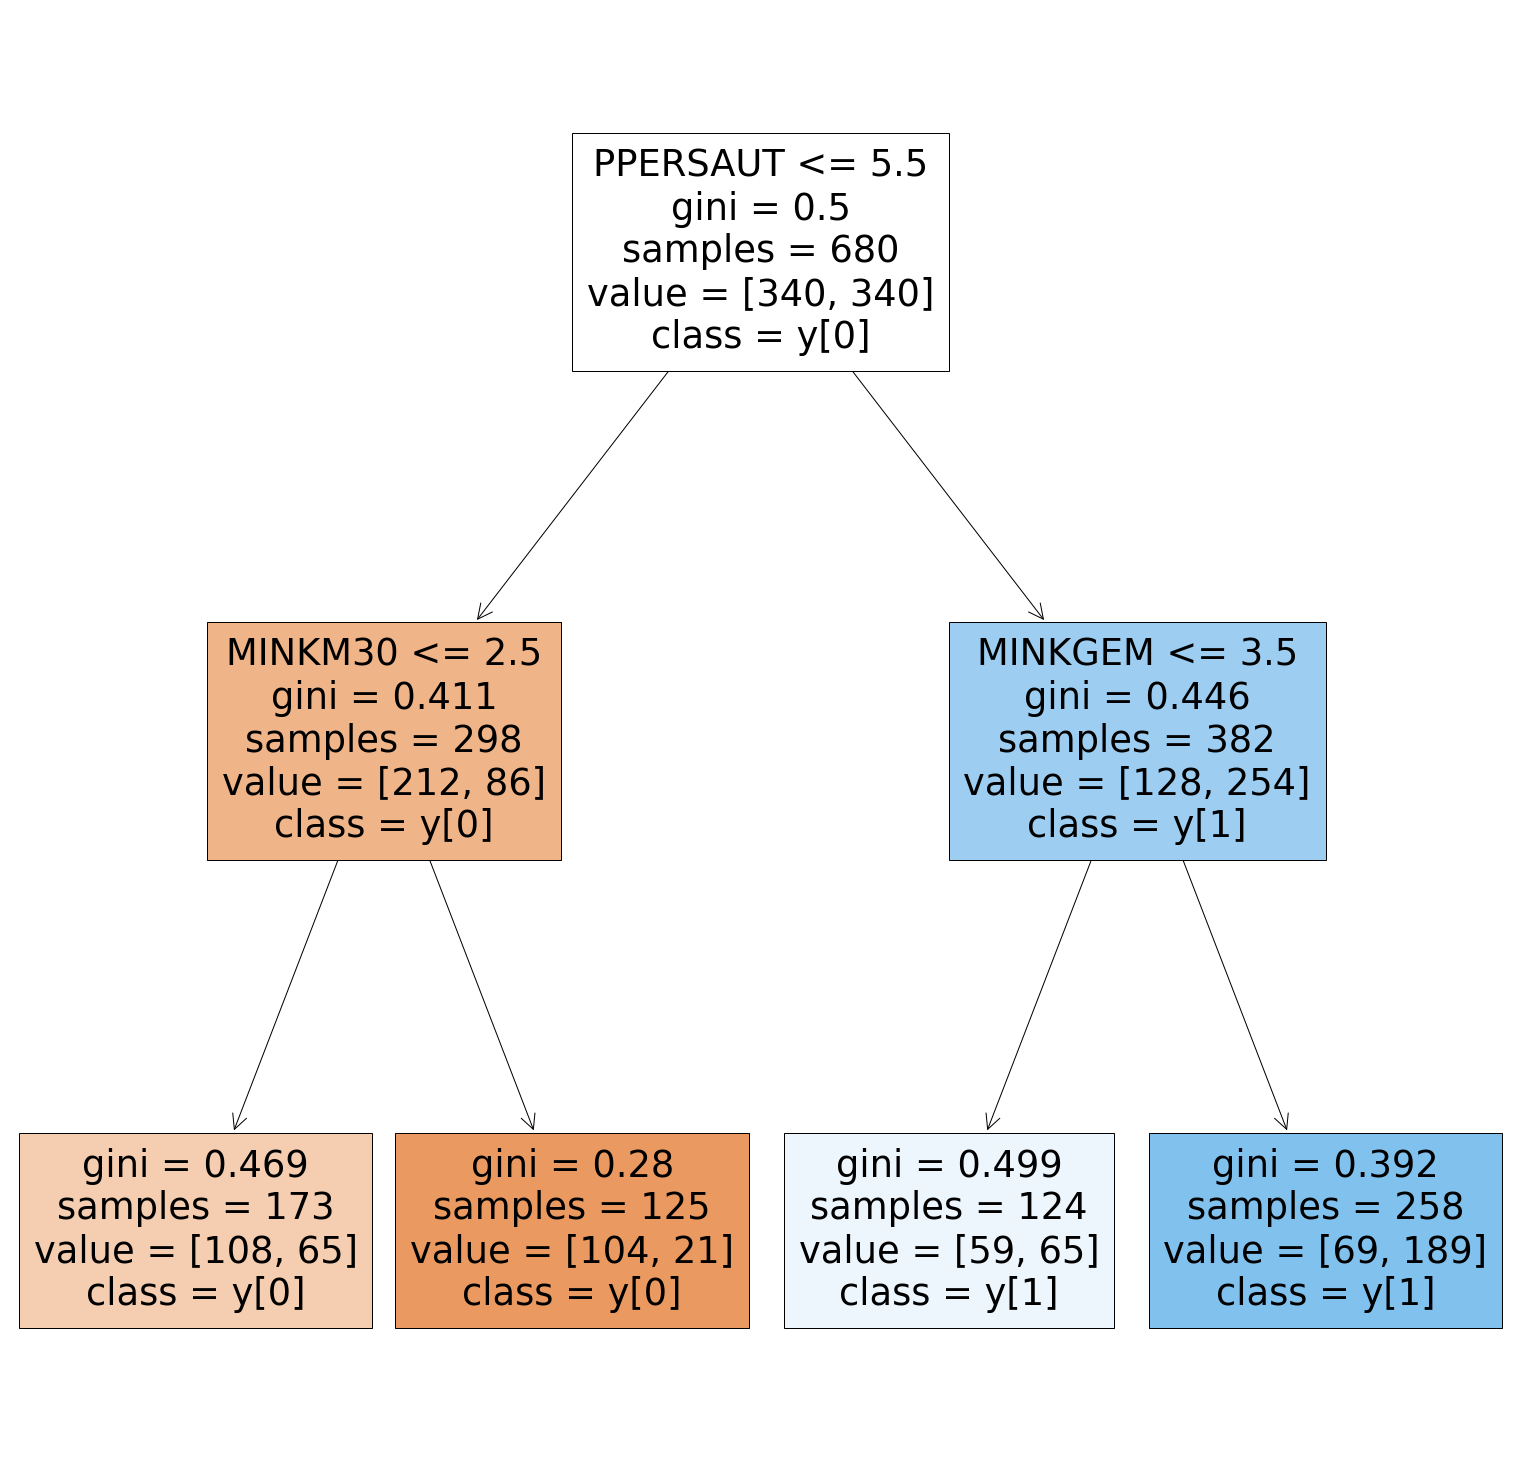

In [214]:
from sklearn.tree import plot_tree
tree_decision = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=2)   
tree_decision.fit(X_train_balanced, y_train_balanced)

fig = plt.figure(figsize=(27,27))
_ = tree.plot_tree(tree_decision, 
                   feature_names = X_train.columns,
                   filled=True,
                   class_names = True)

<h3 style="color: navy bleu"> B. Evaluation du score en fonction de la profondeur 

C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(
C:\Users\saida\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier 

Text(0, 0.5, "Score de l'arbre de décision")

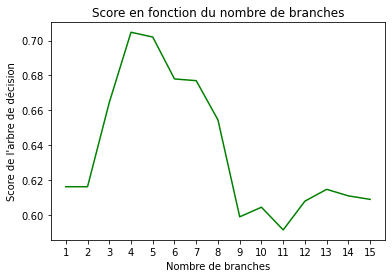

In [207]:
def S(nb_branches):
    decision_tree = DecisionTreeClassifier(max_depth = nb_branches)
    decision_tree.fit(X_train_balanced, y_train_balanced)
    return(decision_tree.score(X_test, y_test))

B = np.arange(1,16)
S_score = []
for k in B:
    S_score.append(S(k))
plt.figure()
plt.plot(B, S_score, color = 'green')
plt.title("Score en fonction du nombre de branches")
plt.xlabel("Nombre de branches")
plt.xticks(B)
plt.ylabel("Score de l'arbre de décision")

<h3 style="color: navy bleu"> B. Validation croisée pour choisir les meilleurs hyperparamètres 

In [190]:
from sklearn import model_selection

param_grid = {'max_depth': [i for i in range(1,11)], 'criterion': ['gini', 'entropy']}

score = 'accuracy'

clf = model_selection.GridSearchCV(
    DecisionTreeClassifier(),
    param_grid,
    cv = 3,
    scoring=score)

clf.fit(X_train_balanced, y_train_balanced)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:")
print(clf.best_params_)

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement:
{'criterion': 'gini', 'max_depth': 1}


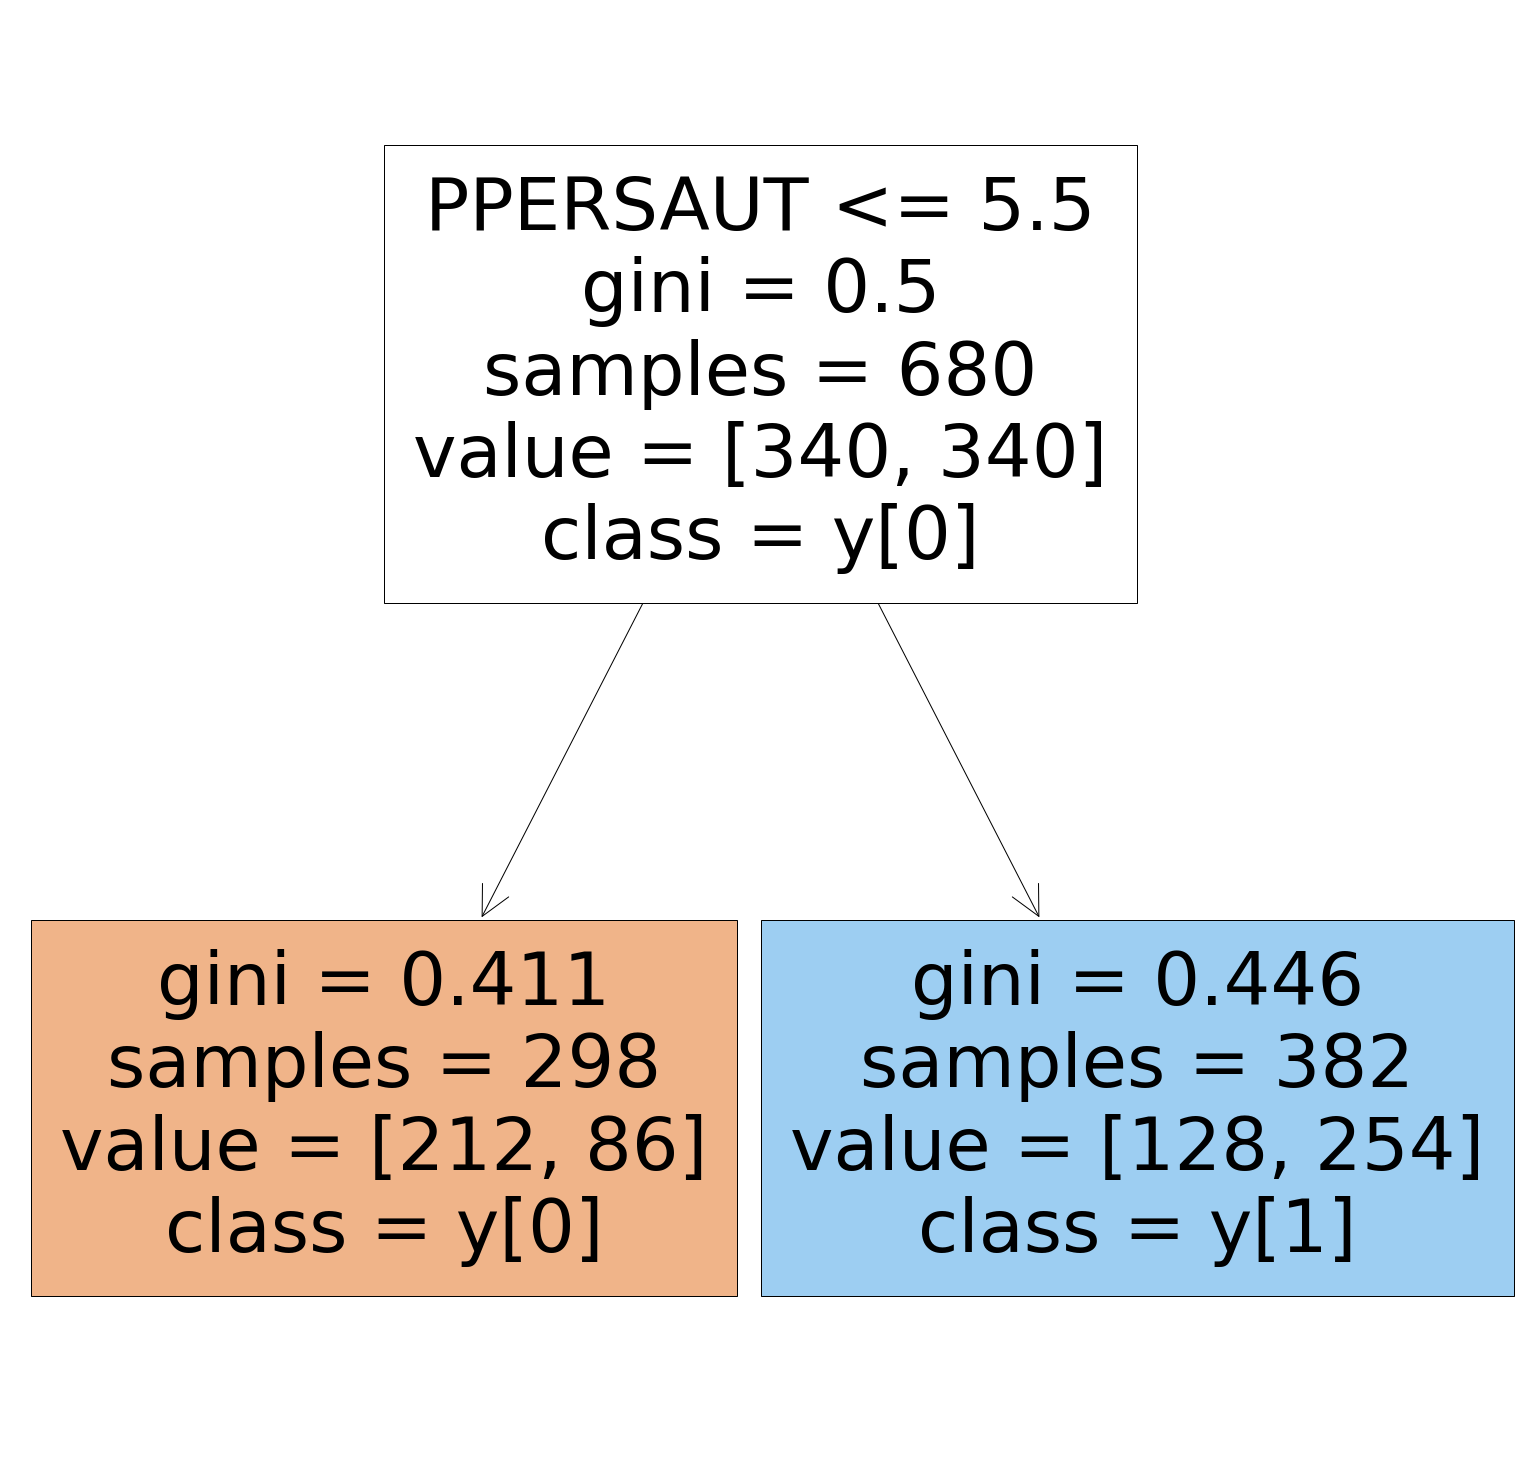

In [208]:
tree_decision = DecisionTreeClassifier(criterion='gini', splitter='best', max_depth=1)   
tree_decision.fit(X_train_balanced, y_train_balanced)

fig = plt.figure(figsize=(27,27))
_ = tree.plot_tree(tree_decision, 
                   feature_names = X_train.columns,
                   filled=True,
                   class_names = True)